In [1]:
import pandas as pd 
from get_dataframes import * 
from constants import *
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import math 
from typing import List, Dict
import re

plt.rcParams['figure.dpi'] = 300

outlier_df = get_outlier_df(success_analysis=False)
cluster_df = get_clusters_df(success_analysis=False)
nonlinearity_df = get_nonlinearity_df(success_analysis=False)

master_df = pd.concat([outlier_df[['model', 'condition', 'tokens_input', 'tokens_used', 'setting', 'response']],
                       cluster_df[['model', 'condition', 'tokens_input', 'tokens_used', 'setting', 'response']], 
                       nonlinearity_df[['model', 'condition', 'tokens_input', 'tokens_used', 'setting', 'response']]], axis=0)

In [2]:
# for supplementary analysis

stats_terms = [
    "mean",
    "min",
    "max",
    "average",
    "variance",
    "standard deviation",
    "correlation",
    "range",
    "domain",
]

def count_words_occurrence(text: str, word_list: List[str]) -> Dict[str, int]:
    # remove punctuation, lowercase
    cleaned = re.sub(r'[^\w\s]', '', text).lower()
    tokens = cleaned.split()
    counts = {word.lower(): 0 for word in word_list}
    
    # tally up count
    for token in tokens:
        if token in counts:
            counts[token] += 1
    
    return sum(counts.values())

In [3]:
def set_three_yticks(ax: plt.Axes):
    y_min, y_max = ax.get_ylim()
    first = math.ceil(y_min / 100) * 100
    last  = math.floor(y_max / 100) * 100

    if first < last:
        mid = (first + last) / 2.0
        mid = round(mid / 50) * 50
        ticks = [first, mid, last]
    else:
        y_max_round = round(y_max, 0)
        ticks = [0, y_max_round // 2, y_max_round if y_max_round % 2 == 0 else y_max_round - 1]

    ax.set_yticks(ticks)

def get_summary_boxes(df:pd.DataFrame, setting:str='outlier', y_col:str='tokens_used'):
    plot_df = df.copy()    
    if y_col == "term_count" or y_col == "normalized_term_count": 
        plot_df['term_count'] = plot_df['response'].apply(lambda x: count_words_occurrence(x, stats_terms))
        plot_df['normalized_term_count'] = plot_df['term_count'] / plot_df['tokens_used']

    # Define y_label mapping
    y_label_map = {
        "tokens_used": "Output Token Count",
        "normalized_term_count": "Statistical Term Proportion", 
        "term_count": "Statistical Term Count"
    }
    y_label = y_label_map.get(y_col)
    if y_label is None:
        raise ValueError(f"Unsupported y_col: {y_col}")

    plot_df['condition'] = plot_df['condition'].map(condition_rename_map)
    plot_df['model']     = plot_df['model'].map(model_rename_map)
    plot_df = plot_df[plot_df['setting'] == setting]

    # 1 row × 2 cols
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.8), sharey=(y_col == "normalized_term_count"))
    hue_order = list(condition_rename_map.values())

    # Define model configurations
    models = ['GPT 4.1', 'Claude 3.5']
    
    # Common boxplot properties
    boxplot_props = {
        'x': 'setting',
        'y': y_col,
        'hue': 'condition',
        'hue_order': hue_order,
        'palette': HEX,
        'width': 1.0,
        'boxprops': dict(linewidth=line_width),
        'whiskerprops': dict(linewidth=line_width),
        'capprops': dict(linewidth=line_width),
        'medianprops': dict(linewidth=line_width),
    }

    for i, model in enumerate(models):
        # Create boxplot
        sns.boxplot(
            data=plot_df[plot_df['model'] == model],
            ax=axes[i],
            **boxplot_props
        )
        
        # Configure axis
        axes[i].set_title(model, fontsize=font_size, loc='left')
        axes[i].set_xlabel('')
        axes[i].set_xticks([])
        axes[i].tick_params(axis='both', which='both', labelsize=label_size)
        
        # Set y-label only for left plot
        if i == 0:
            axes[i].set_ylabel(y_label, fontsize=font_size)
        else:
            axes[i].set_ylabel('')
        
        # Set y-ticks
        if y_col == "normalized_term_count" and i == 1:
            axes[i].set_yticks([0, 0.02, 0.04])
            axes[i].set_yticklabels(['0', '0.02', '0.04'])
        else:
            set_three_yticks(axes[i])

    # Remove individual legends and create single legend
    for ax in axes:
        if ax.legend_ is not None:
            ax.legend_.remove()

    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend(
        handles, labels,
        title='Condition',
        bbox_to_anchor=(1.22, 0.926),
        ncol=1,
        fontsize=legend_size,
        title_fontsize=font_size
    )

    for patch in leg.legend_handles:        # or: for patch in leg.get_patches():
        patch.set_edgecolor('black')        # outline colour
        patch.set_linewidth(0)            # outline thickness

    plt.tight_layout()
    plt.show()

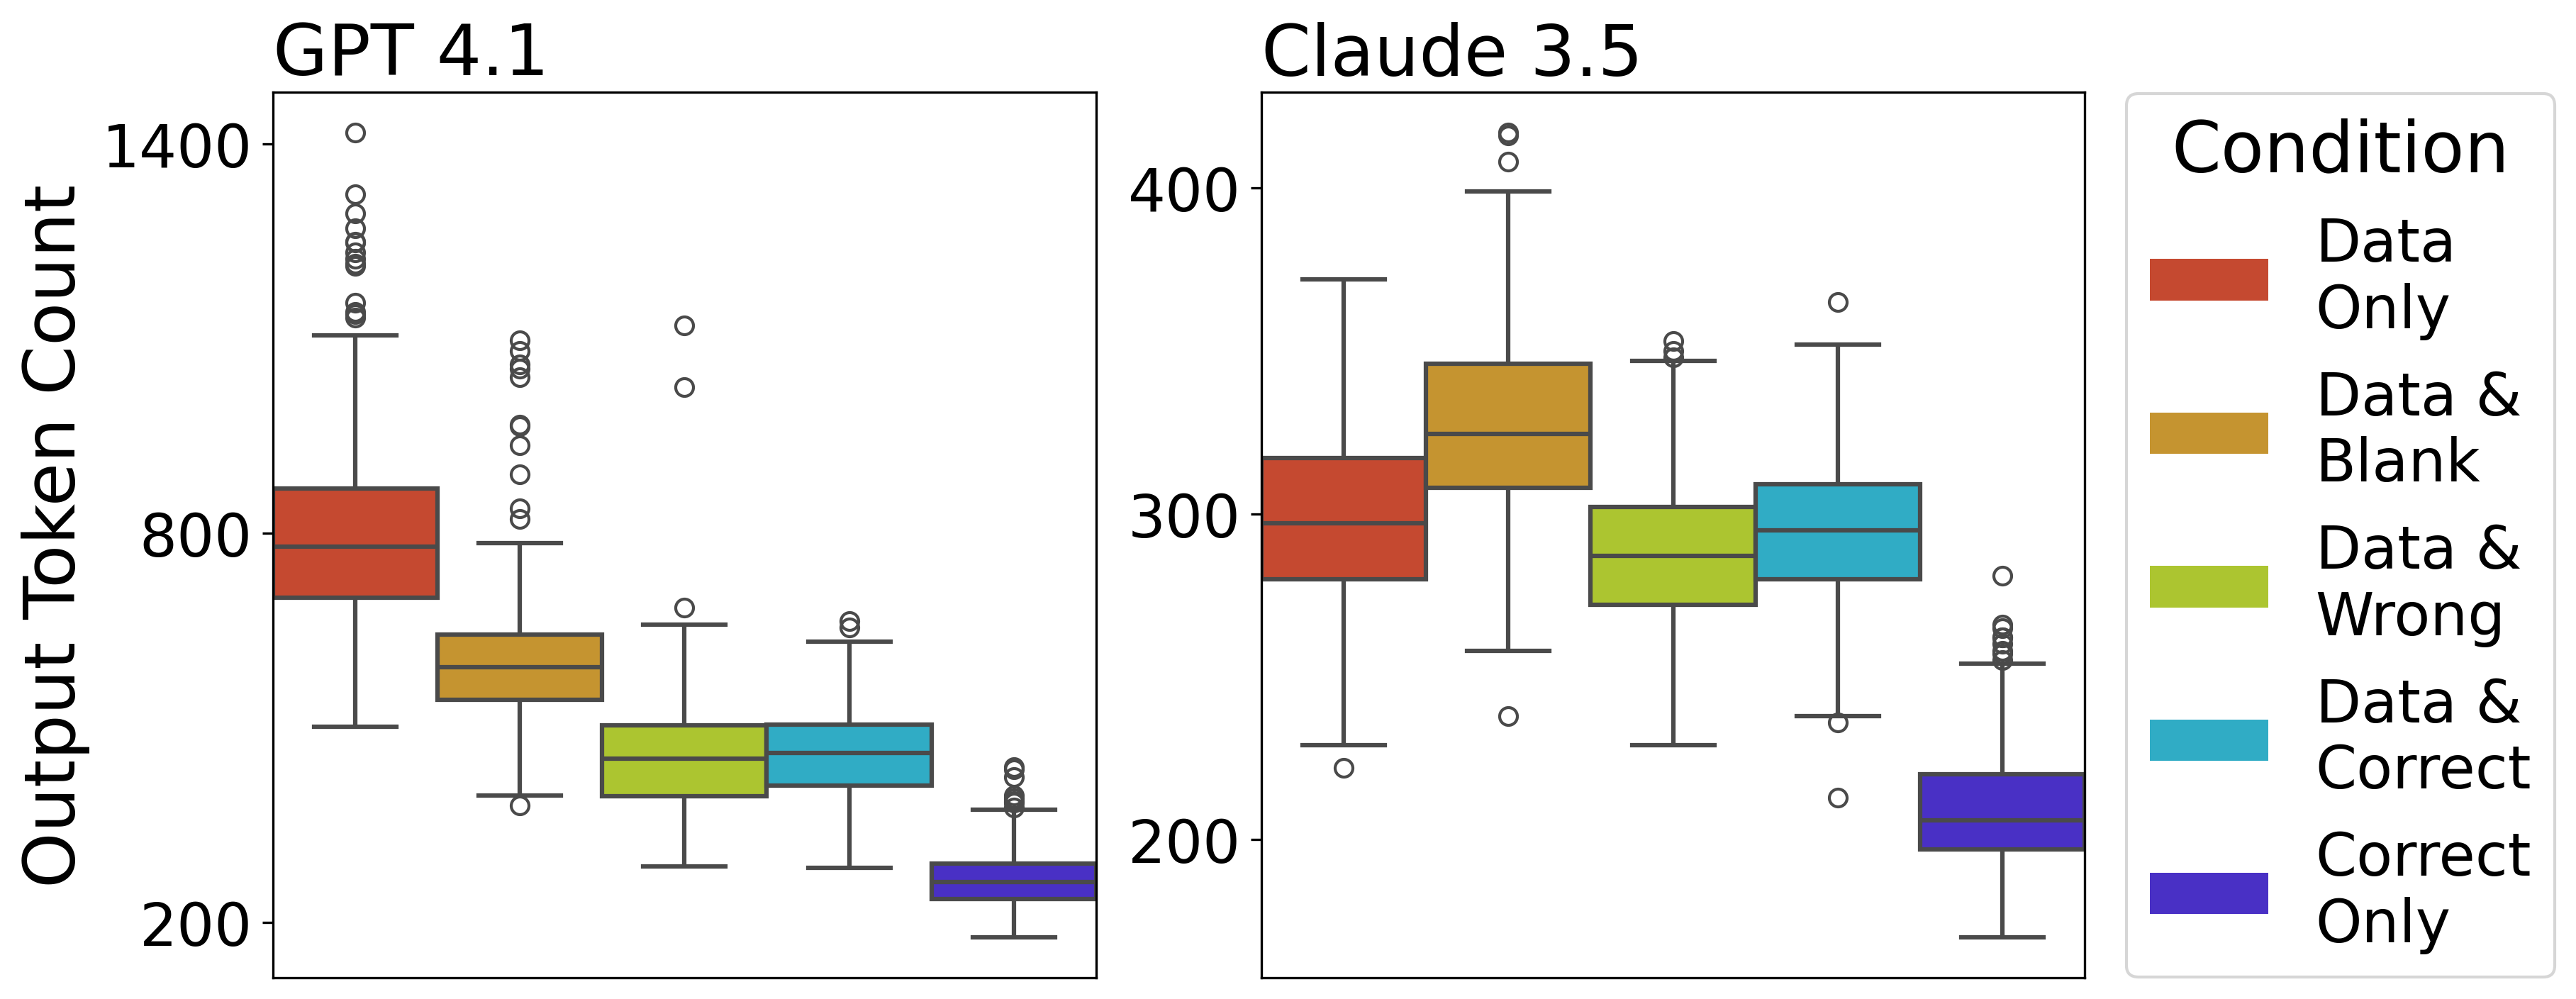

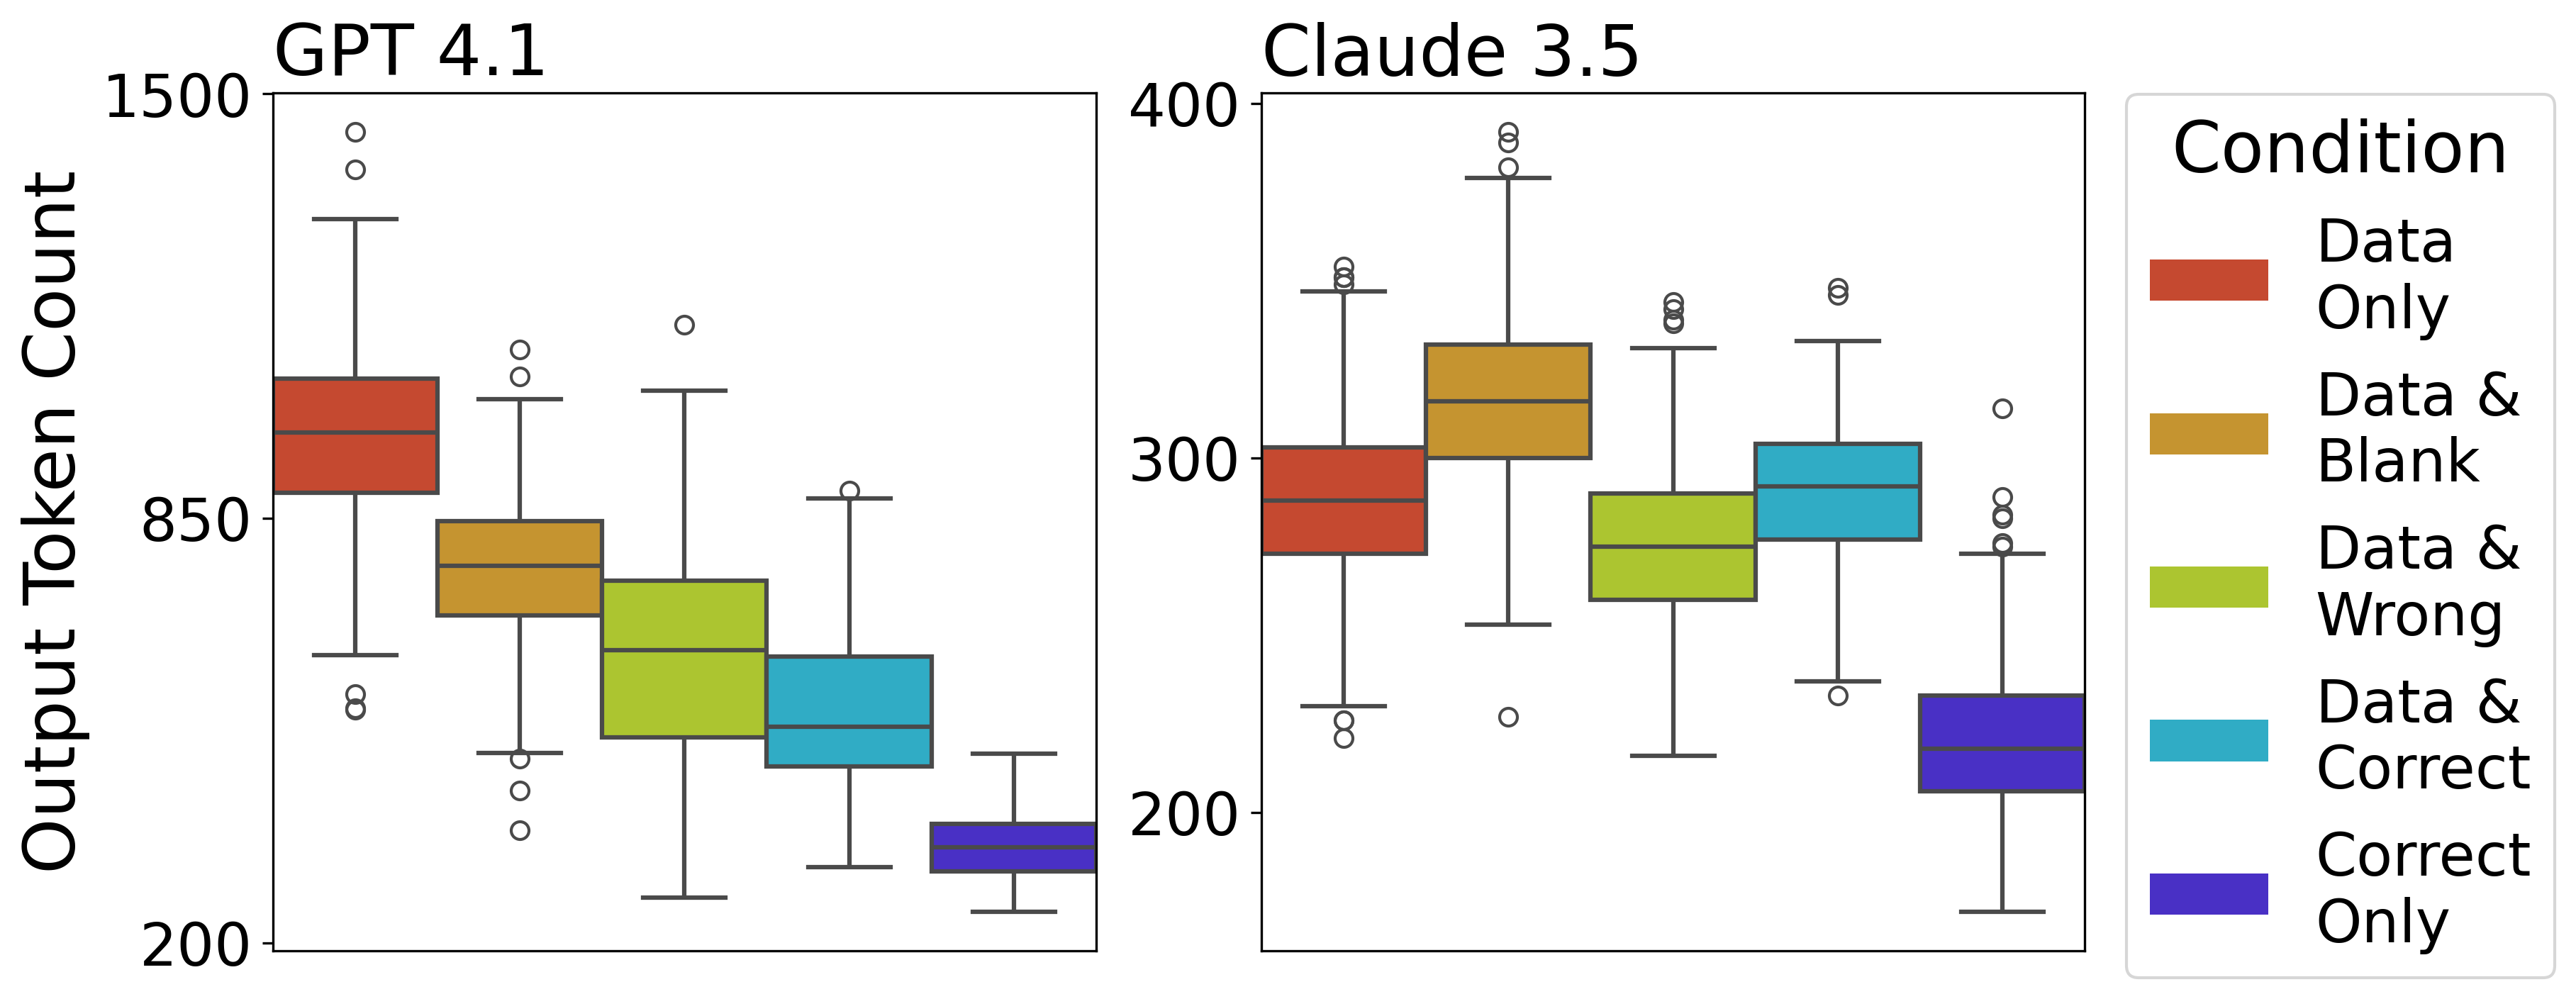

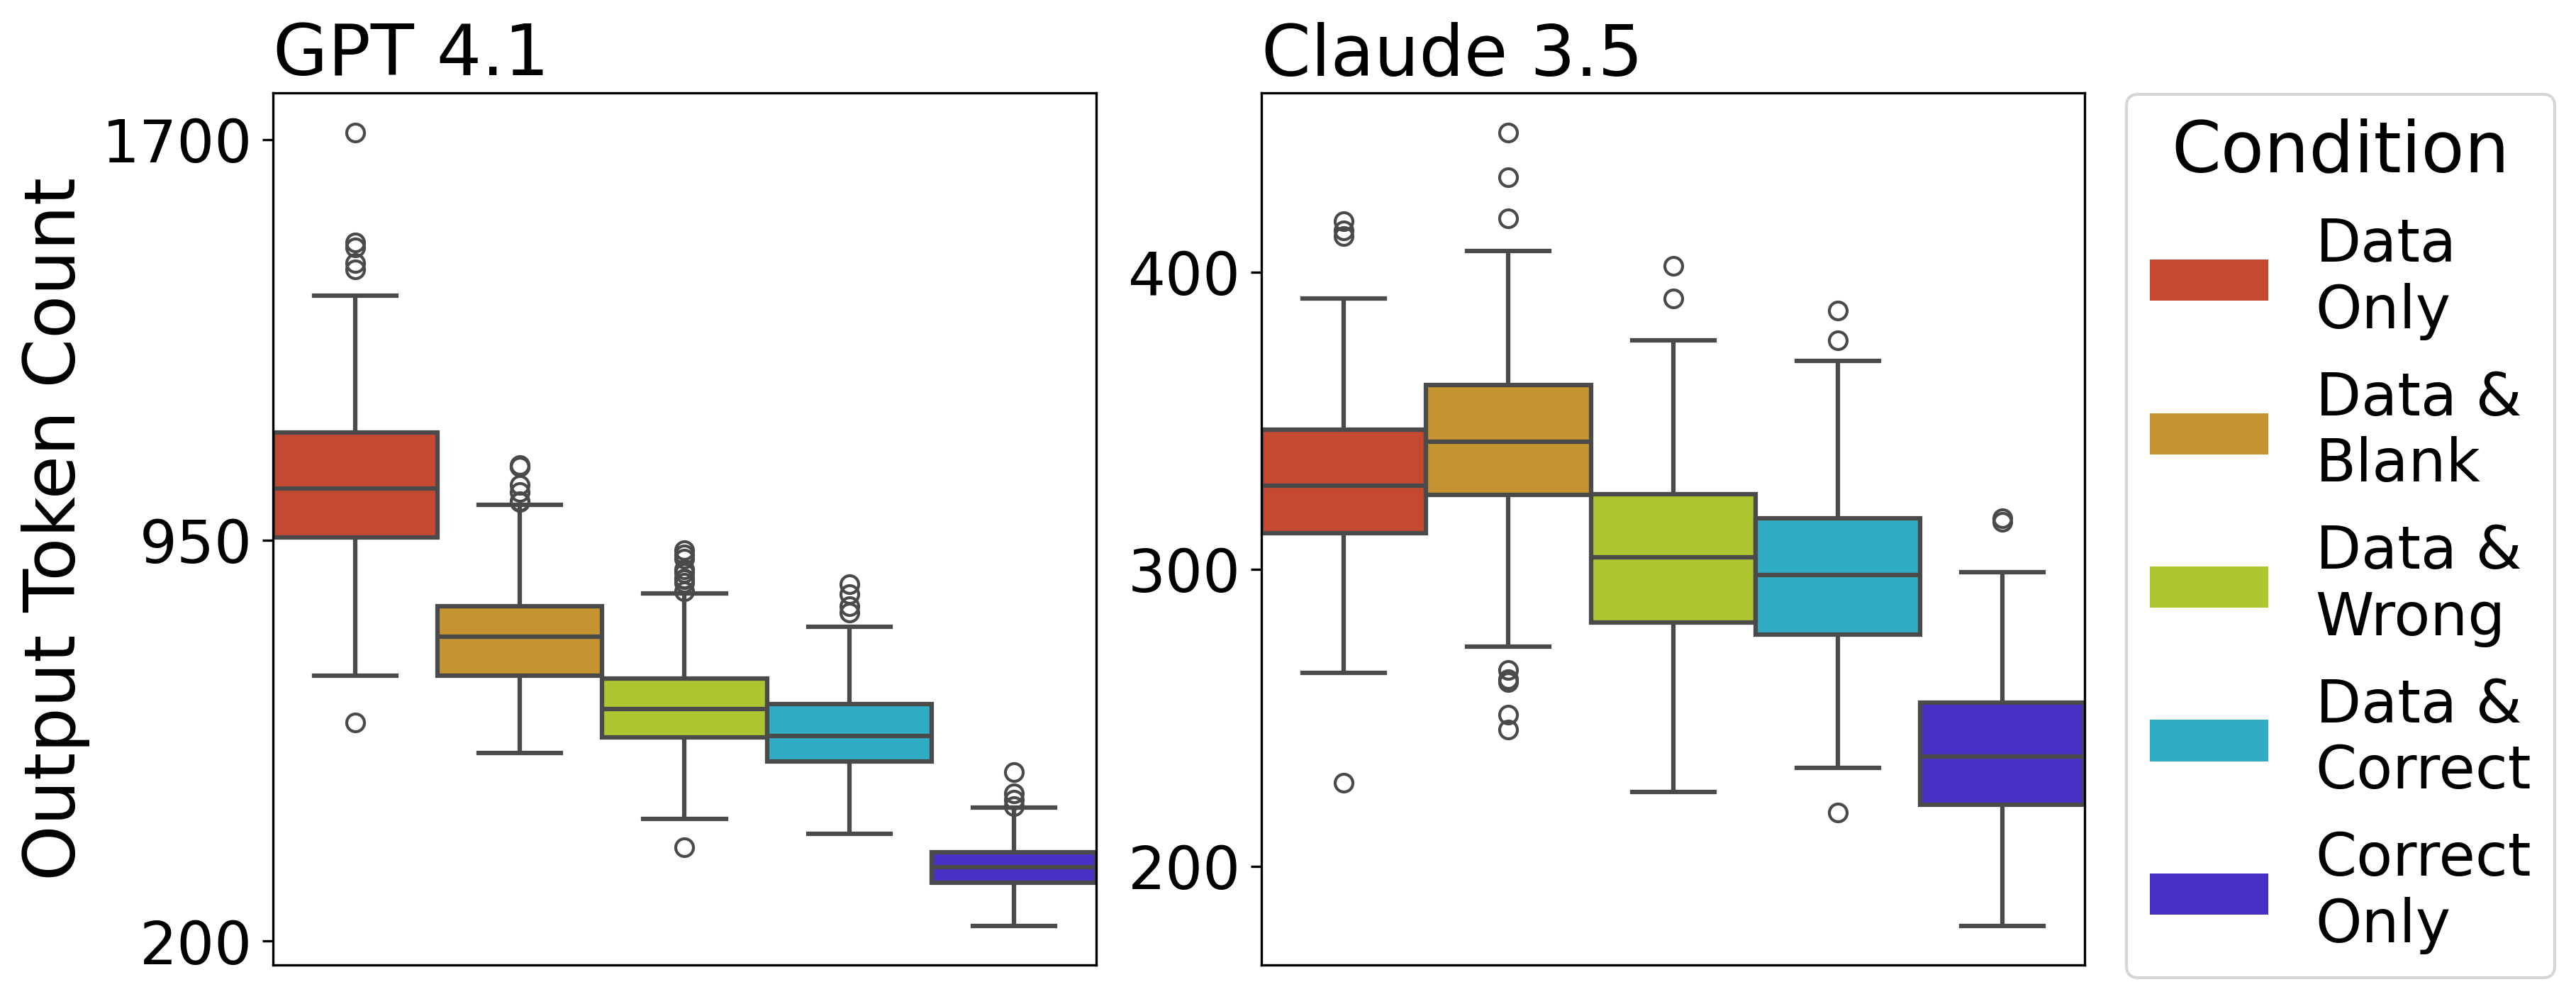

In [4]:
# outlier arbitrarily included in paper
get_summary_boxes(master_df, 'outlier')
get_summary_boxes(master_df, 'nonlinearity')
get_summary_boxes(master_df, 'cluster')

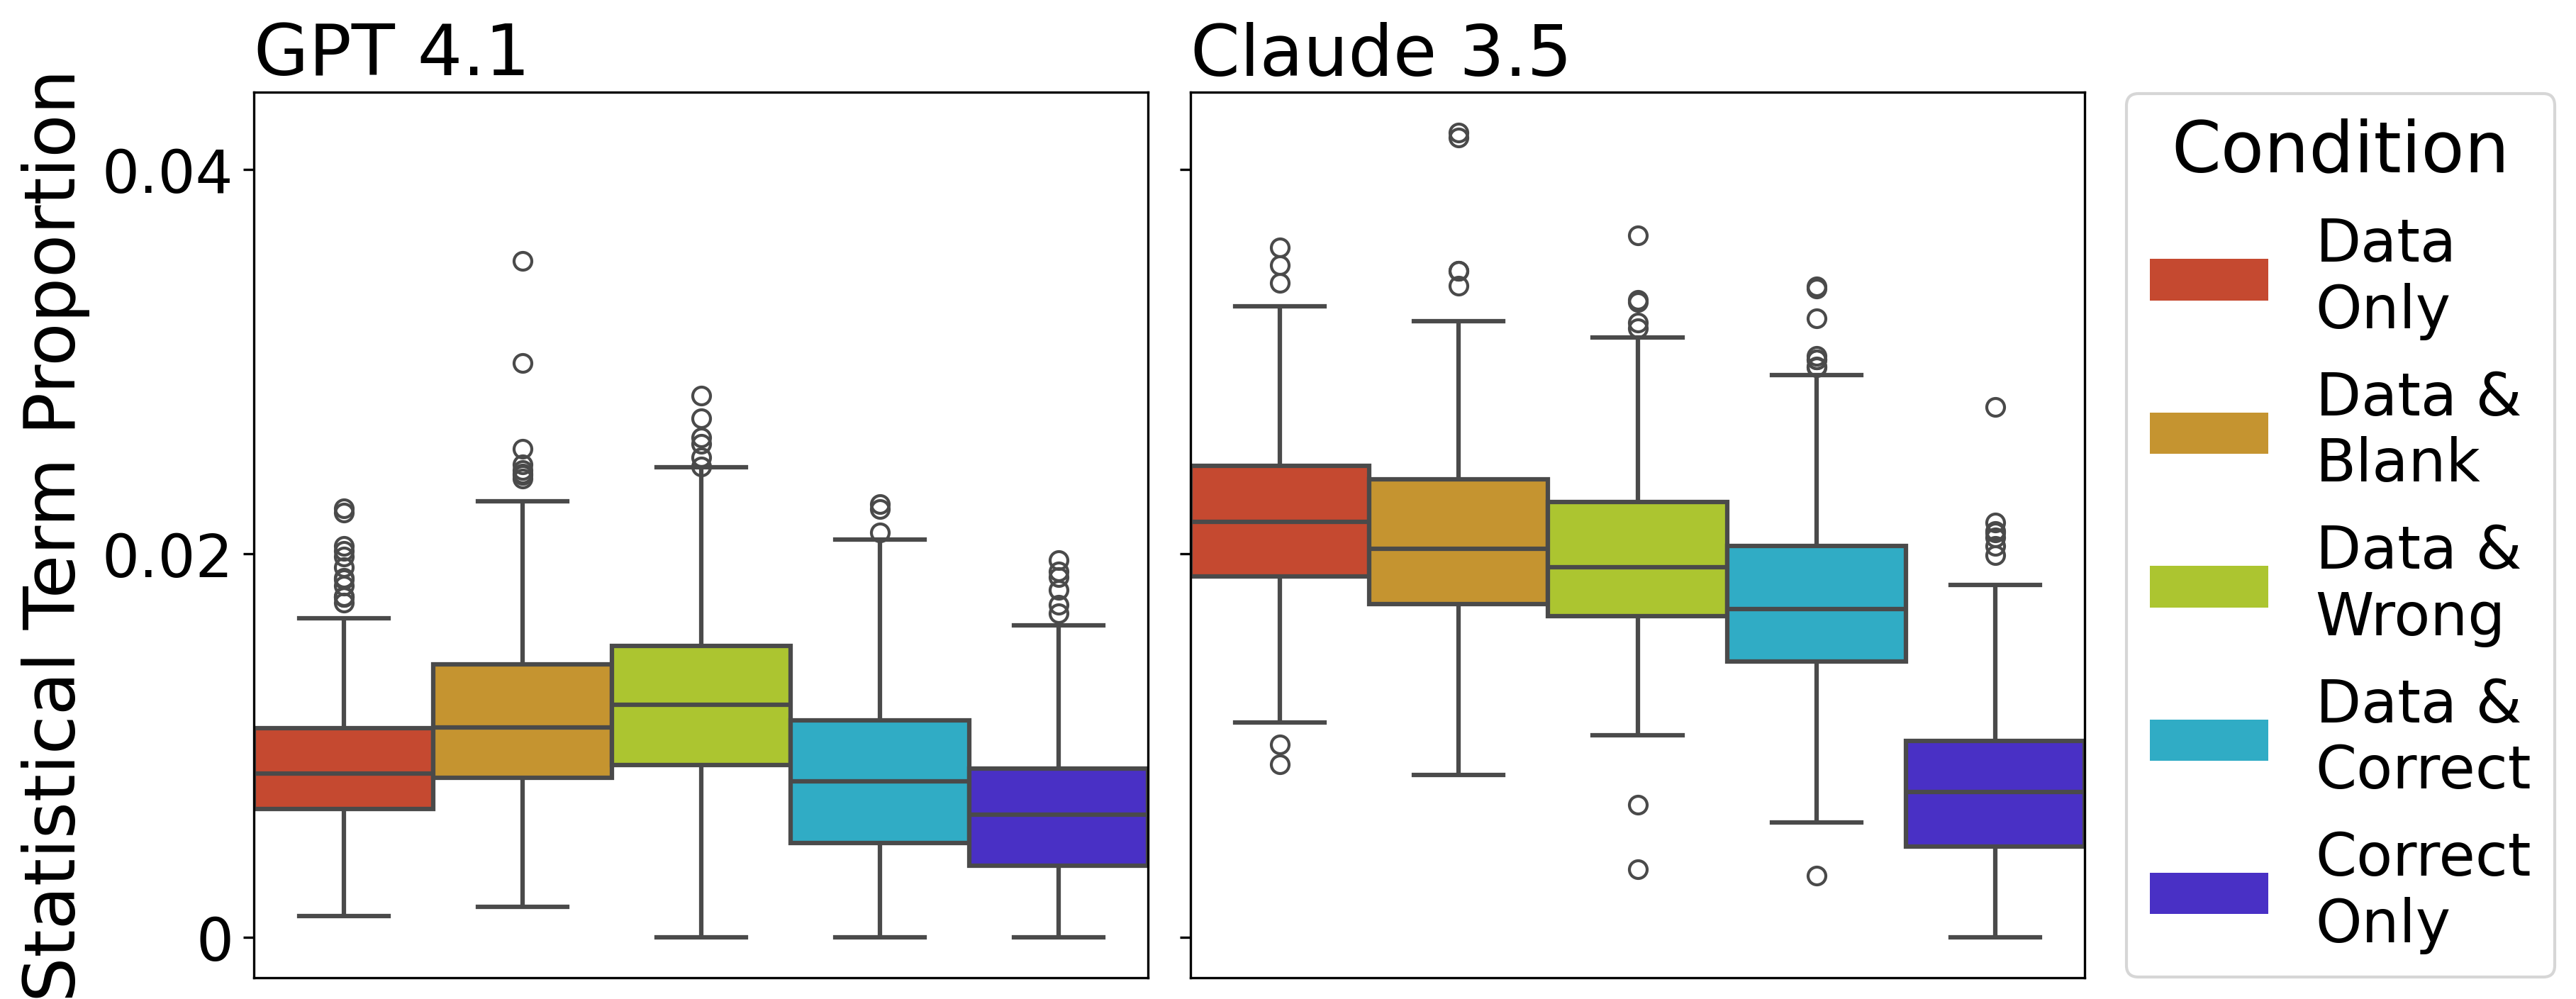

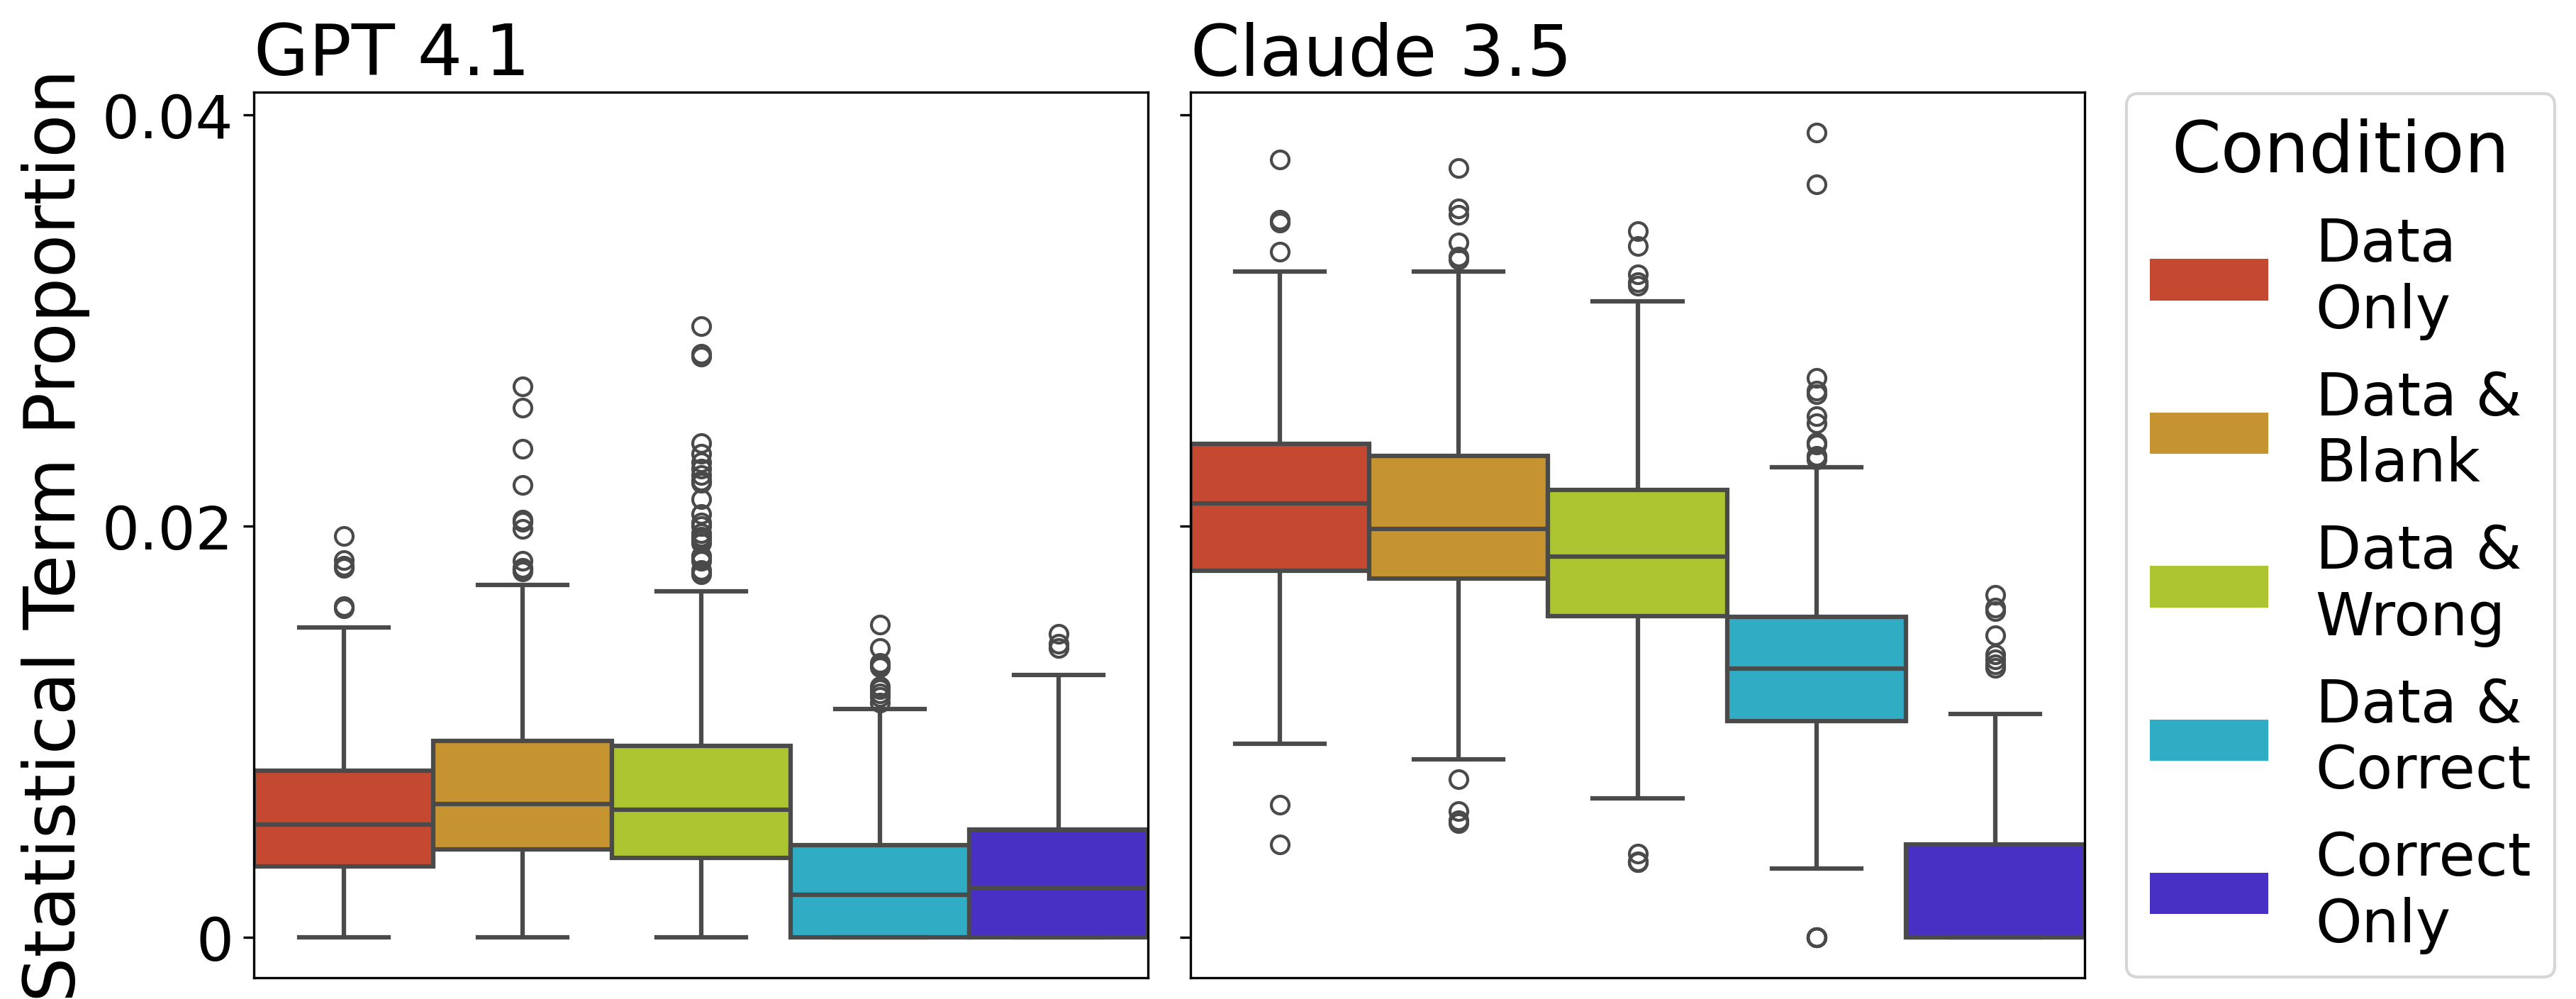

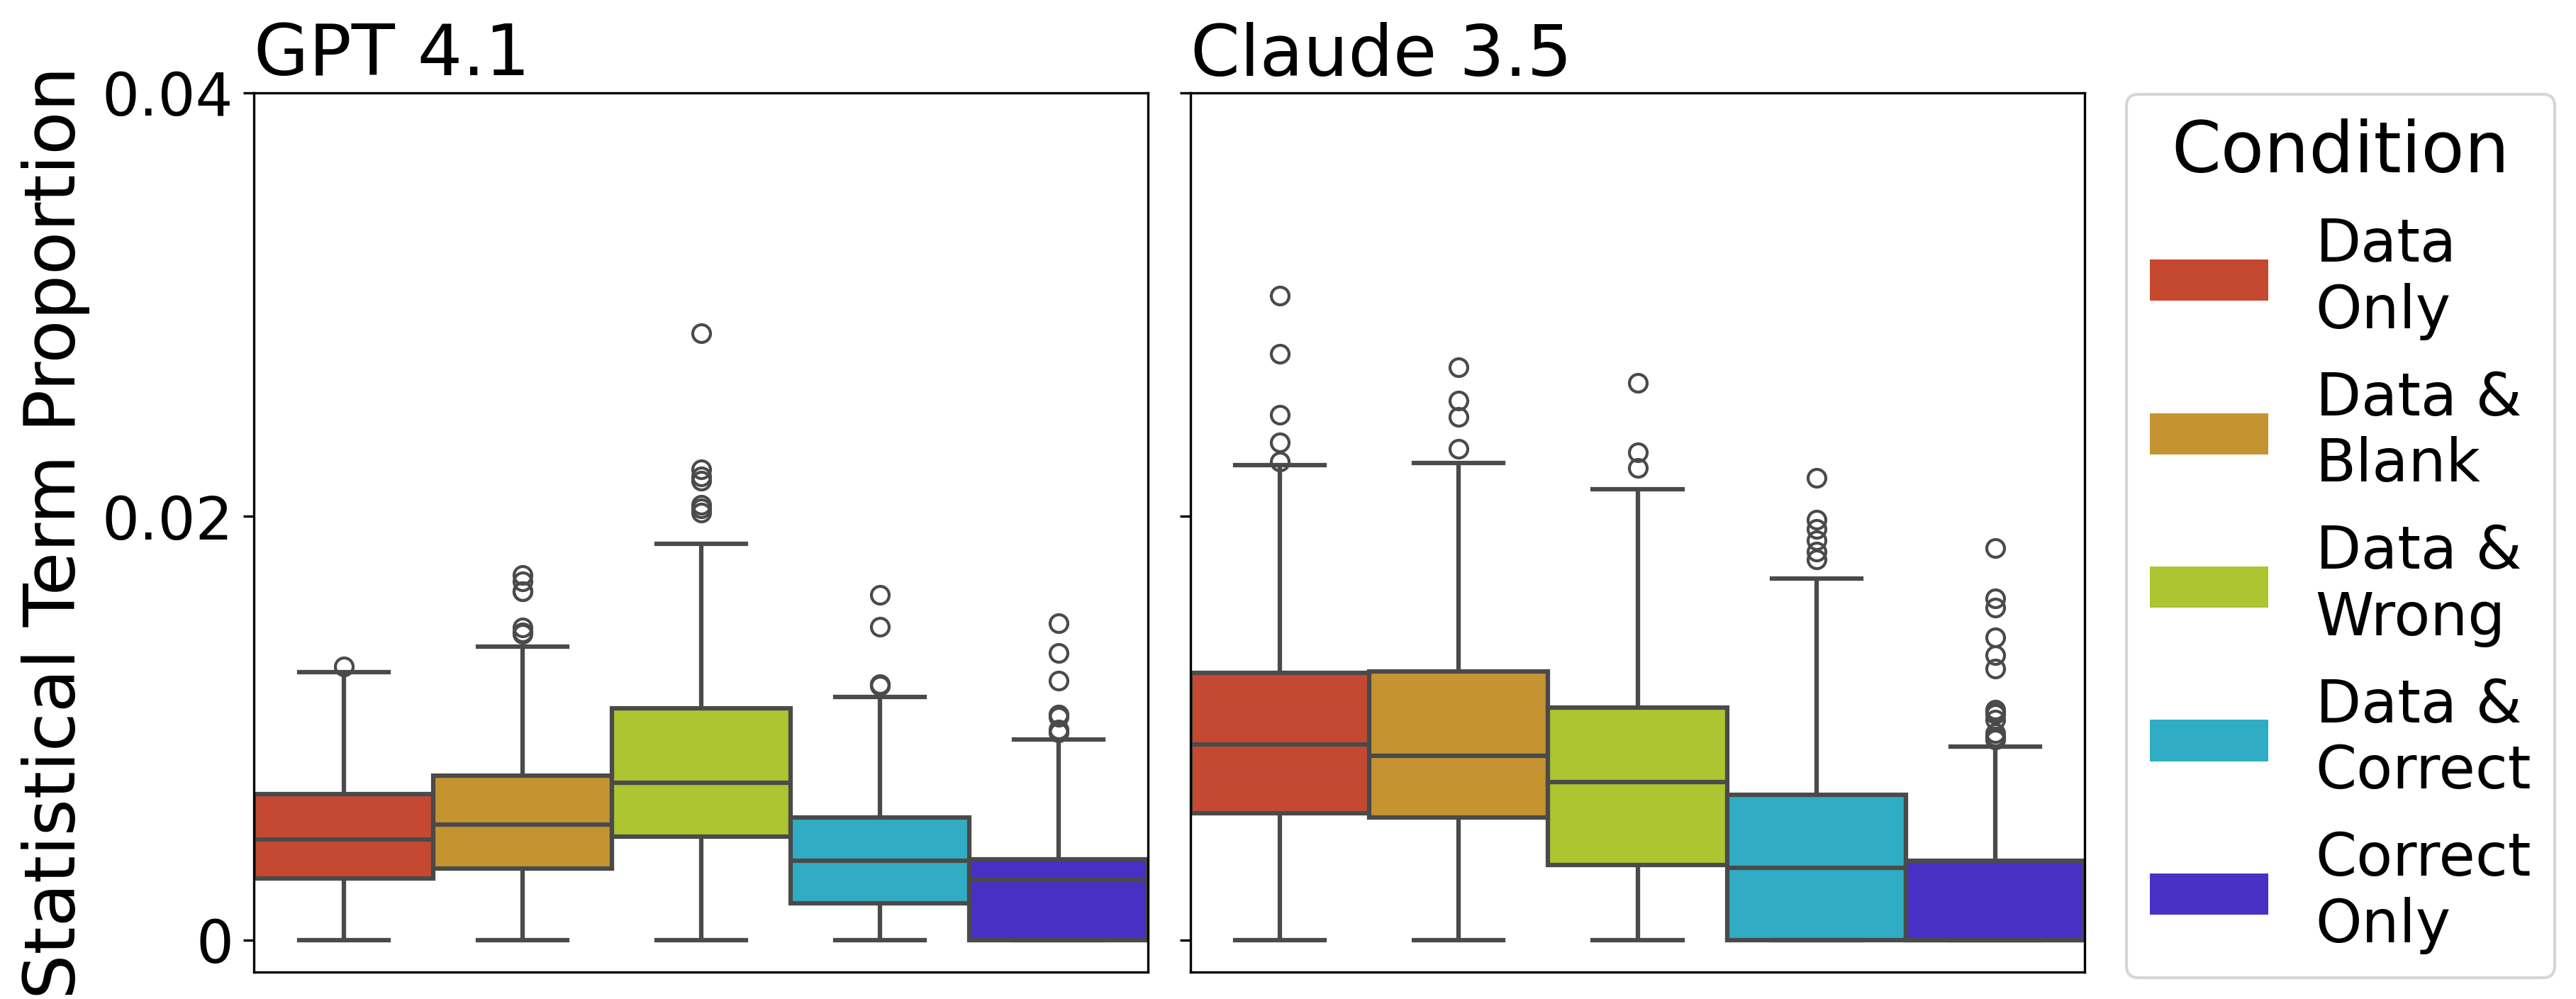

In [ ]:
# supplementary figures
get_summary_boxes(master_df, 'outlier', 'normalized_term_count')
get_summary_boxes(master_df, 'nonlinearity', 'normalized_term_count')
get_summary_boxes(master_df, 'cluster', 'normalized_term_count')

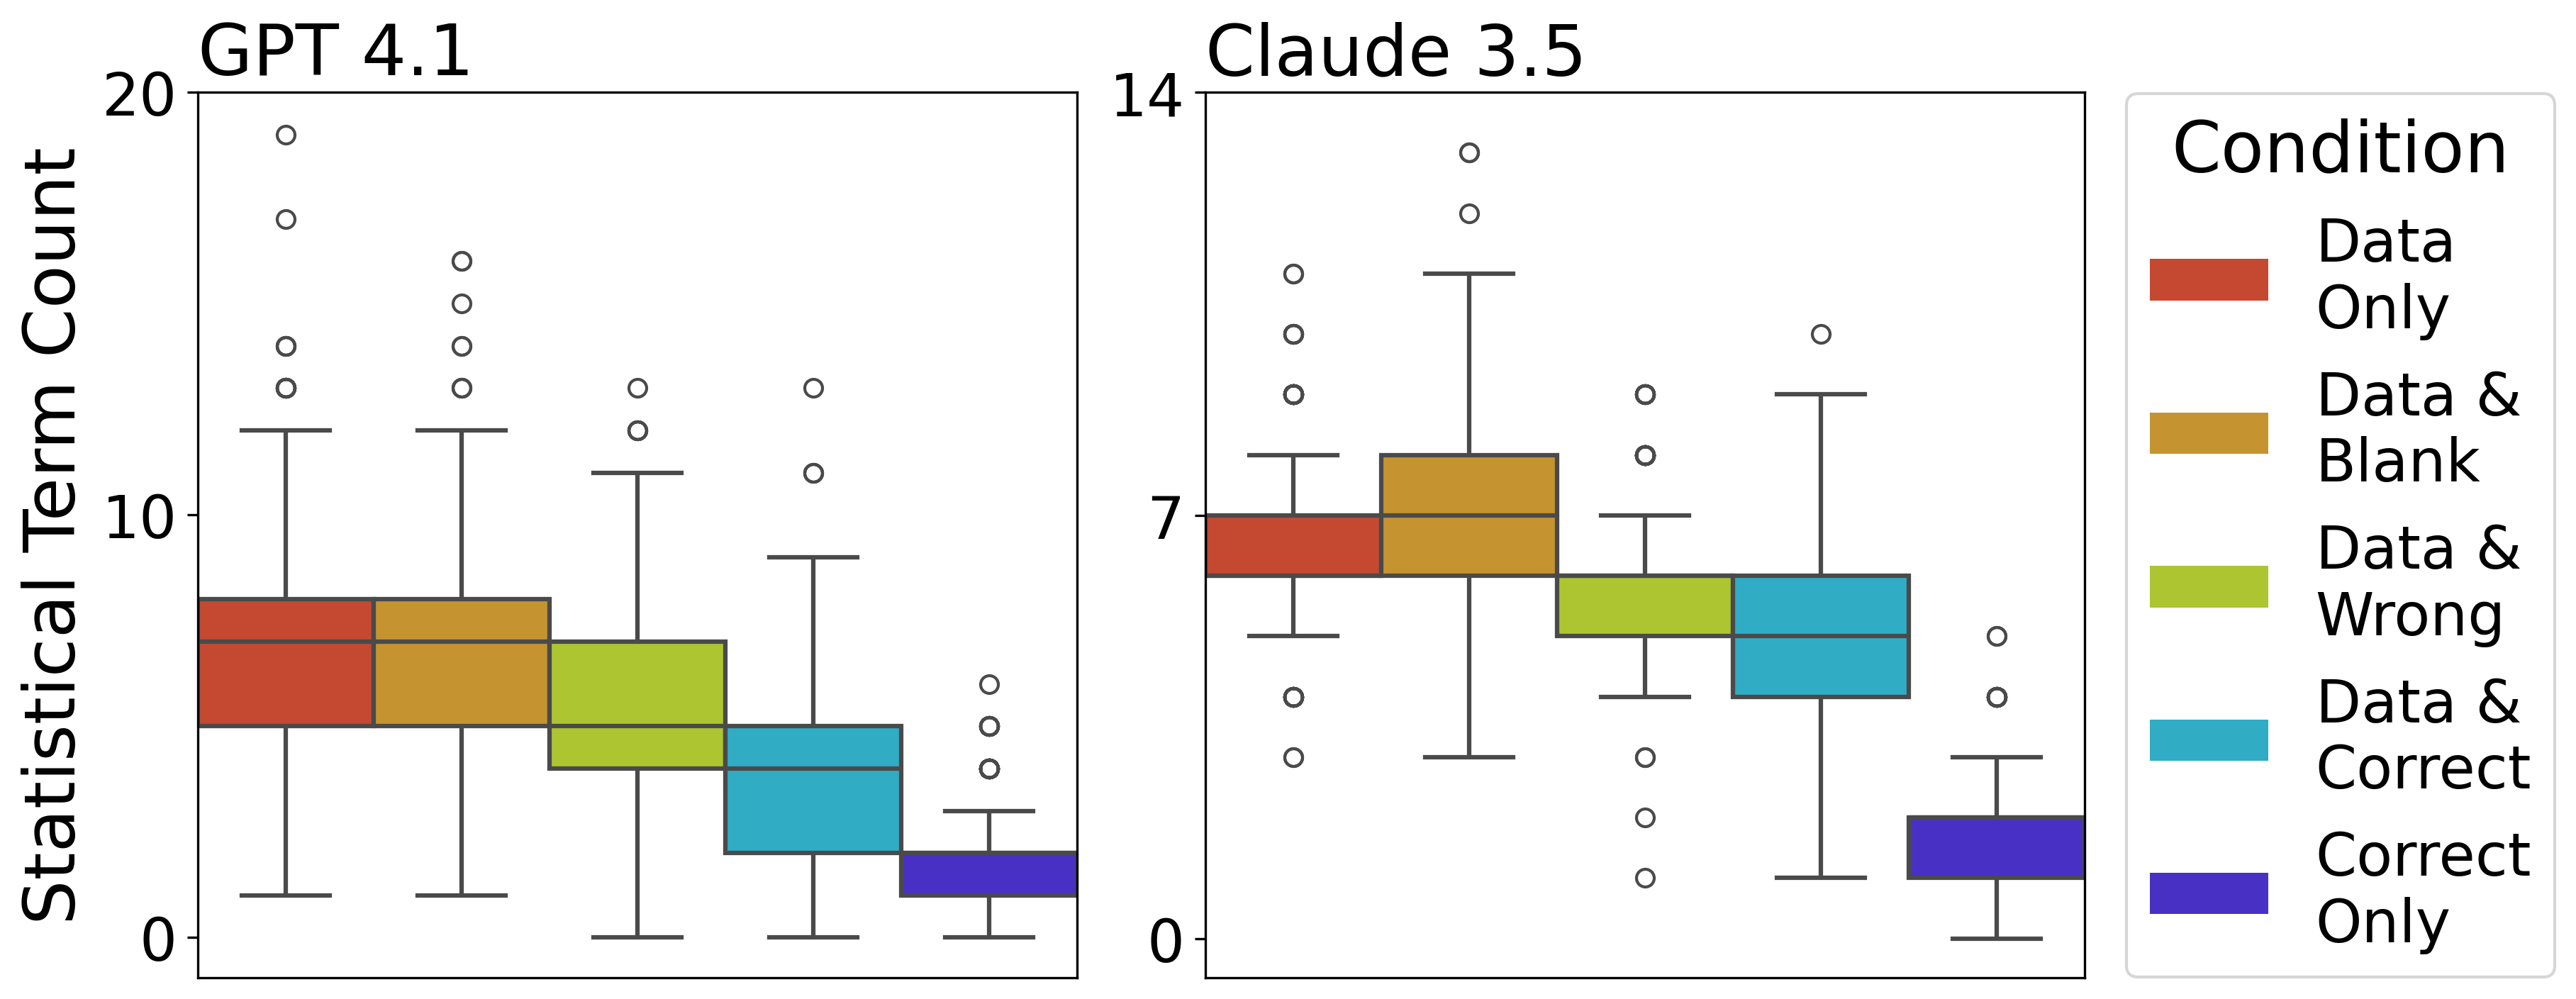

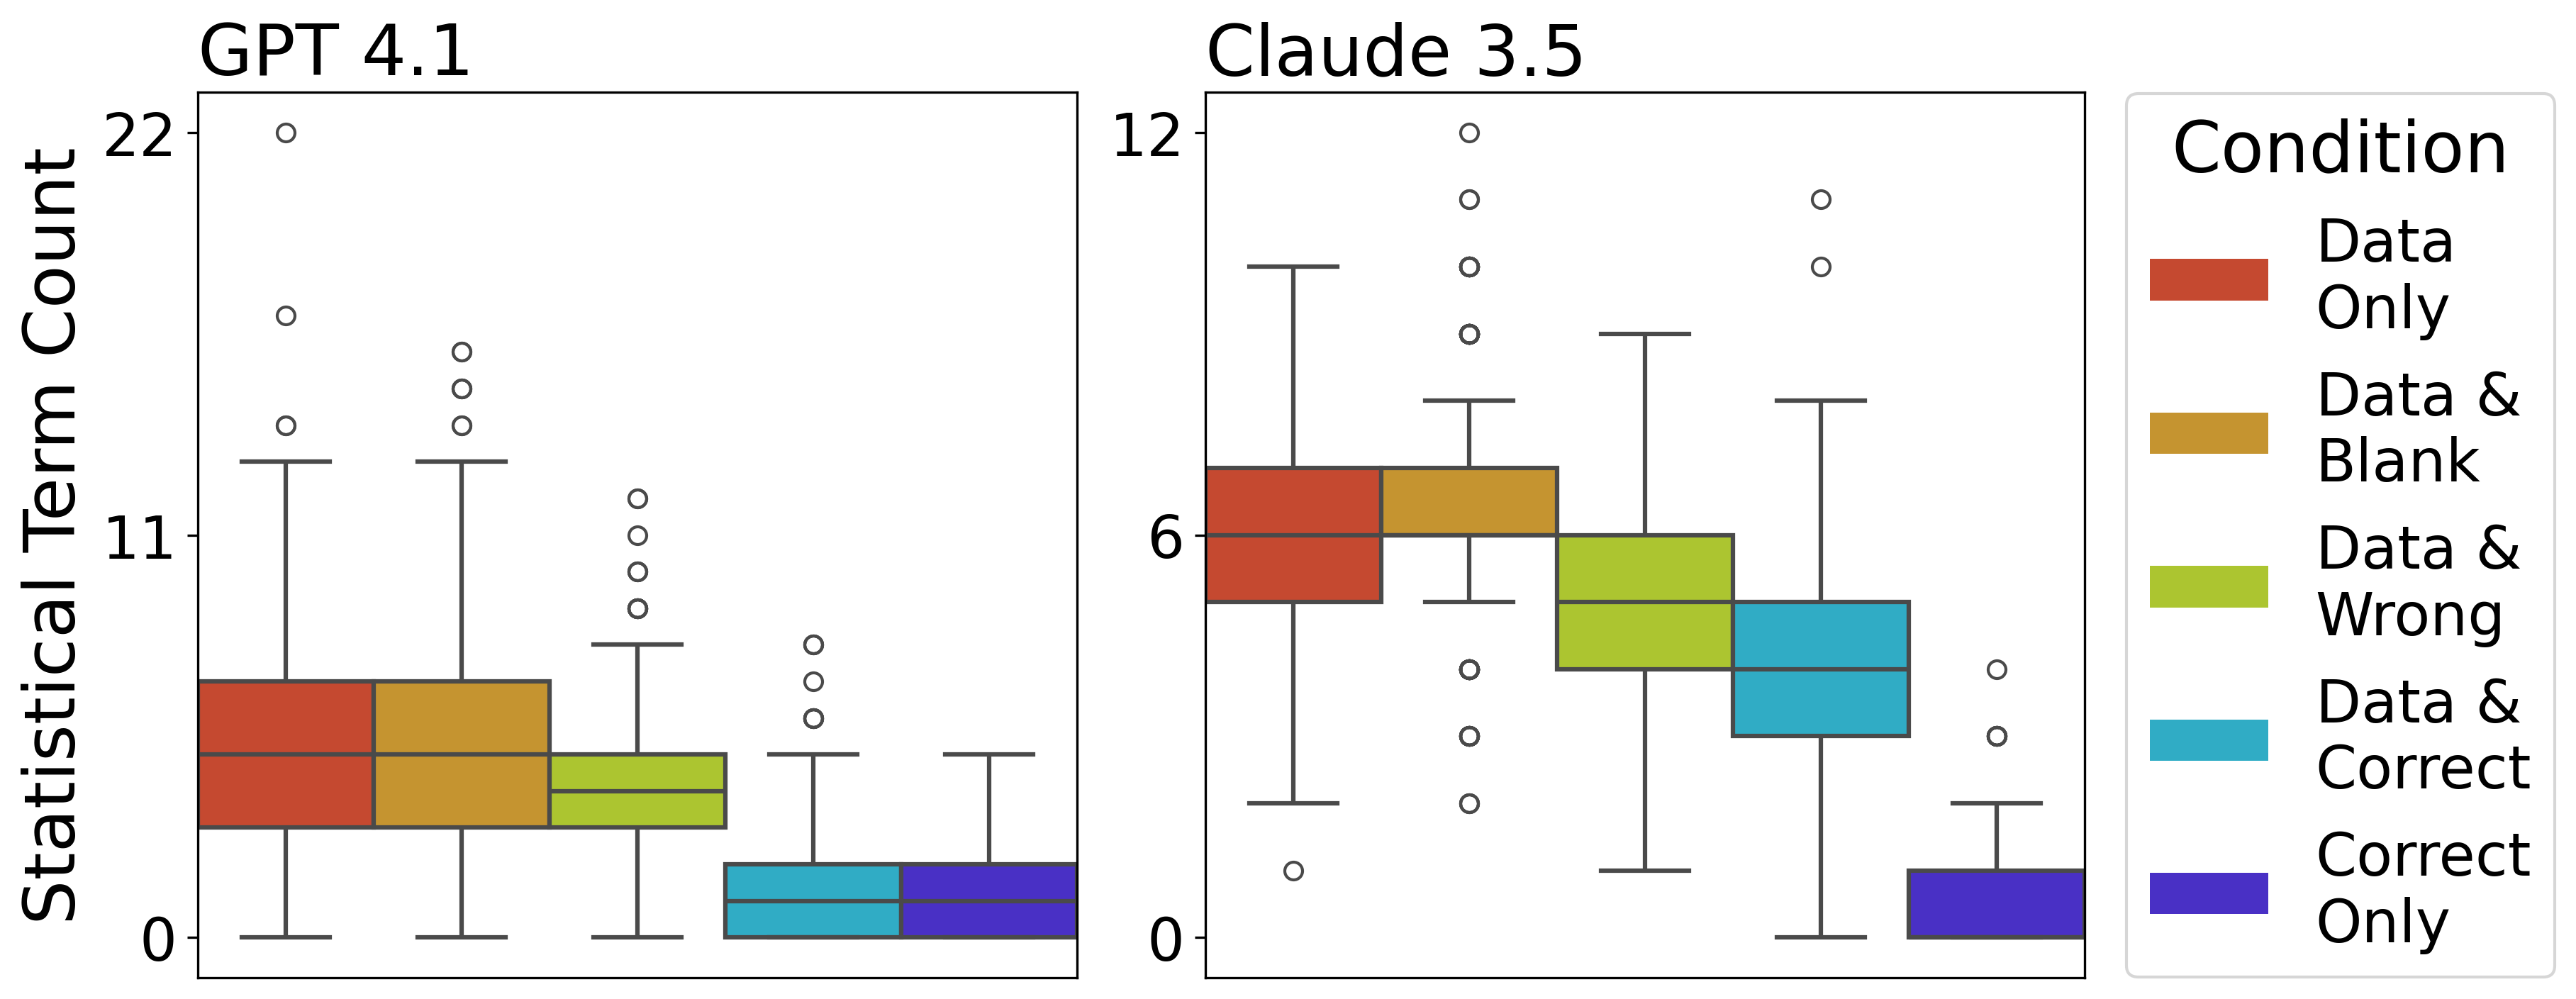

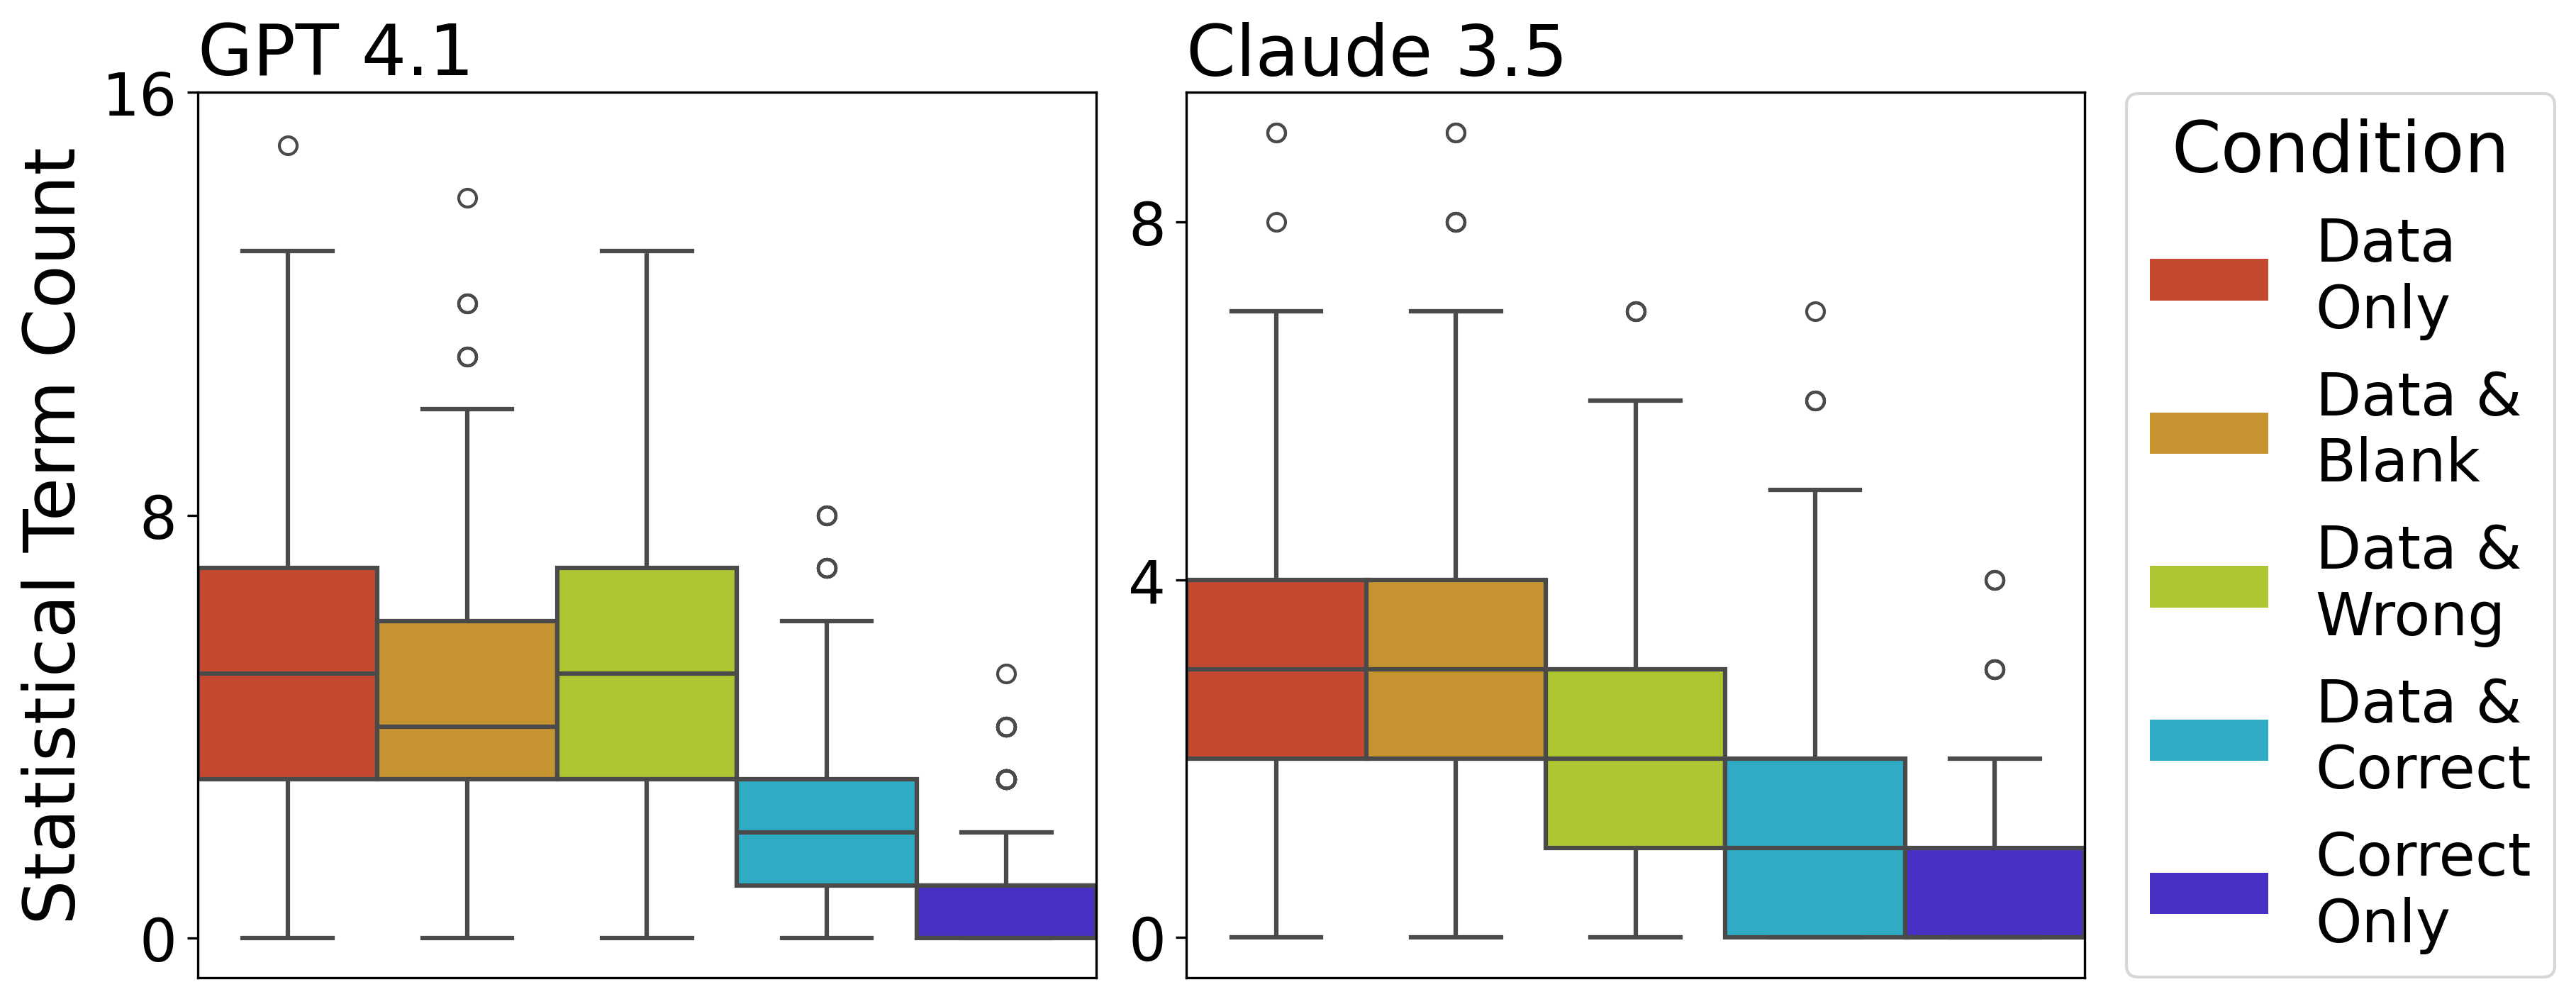

In [ ]:
# supplementary figures
get_summary_boxes(master_df, 'outlier', 'term_count')
get_summary_boxes(master_df, 'nonlinearity', 'term_count')
get_summary_boxes(master_df, 'cluster', 'term_count')